In [1]:
import cv2
import numpy as np
import json
import scipy.signal

import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

with open("iref_trim_per_module.json", "r") as f:
    data = json.load(f)

# Nombre de fils prévu

In [2]:
# Extraire le numéro de série d'un module depuis le nom du fichier

def extract_serial_number (file_name) :
    names = file_name.split("_")
    for x in names :
        if "20UPGM" in x :
            return (x)
    return (None)

In [3]:
# Lire les bits iref codés dans le json

def iref_trim (serialNumber, data) :
    ok = False
    for x in data :
        if x['serialNumber'] == serialNumber :
            iref = x
            ok = True
    assert ok, "serialNumber not found"
    return (iref['IREF_TRIM_1'], iref['IREF_TRIM_2'], iref['IREF_TRIM_3'], iref['IREF_TRIM_4'])

In [4]:
# Donner le nombre de fils attendus pour un certain module

def expected_wire_number (serialNumber, data) :
    iref = iref_trim(serialNumber, data)
    nb_wire_per_trim = [4, 3, 3, 2, 3, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 0]
    return (693 + nb_wire_per_trim[iref[0]] + nb_wire_per_trim[iref[1]] + nb_wire_per_trim[iref[2]] + nb_wire_per_trim[iref[3]])

# Comptage du nombre de fils réel

In [383]:
# Définir une zone verticale de recherche de fils (entre high et low)

def crop_lignes (image, level = 0.55) :
    green = image[:,:,1].sum(axis=1) / (image[:,:,0].sum(axis=1) + image[:,:,2].sum(axis=1))
    n = image.shape[0]
    limit_high = 0
    x = green[limit_high]
    while (limit_high < n//2) and (x <= level) :
        limit_high+=1
        x = green[limit_high]
    limit_low = n-1
    x = green[limit_low]
    while (limit_low > n//2) and (x <= level) :
        limit_low-=1
        x = green[limit_low]
    return (limit_high + 25, limit_low - 22)

In [437]:
def count (image_grey_crop, column) :
    peaks, _ = scipy.signal.find_peaks(image_grey_crop[:,column], distance=3, prominence=50, height=190, width=(0,9))
    return (peaks.shape[0])

In [385]:
def crop_colonnes_left (image_grey_crop, level = 100) :
    n = image_grey_crop.shape[1]
    left = 0
    count_left = count(image_grey_crop, left)
    while (count_left < level) and (left < n) :
        left += 1
        count_left = count(image_grey_crop, left)
    return (left)

In [388]:
def crop_colonnes_right (image_grey_crop, level = 100) :
    n = image_grey_crop.shape[1]
    right = n - 1
    count_right = count(image_grey_crop, right)
    while (count_right < level) and (right > 0) :
        right -= 1
        count_right = count(image_grey_crop, right)
    return (right)

In [392]:
def test_wire_number (file_name, data) :
    expected_nb = expected_wire_number(extract_serial_number(file_name), data)
    image = cv2.imread("ModulePictures/" + file_name)
    n = image.shape[1]
    high_l, low_l = crop_lignes(image[:,:n//2])
    high_r, low_r = crop_lignes(image[:,n//2:])
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    left = crop_colonnes_left(grey[high_l:low_l])
    right = crop_colonnes_right(grey[high_r:low_r])
    real_nb_left = count(grey[high_l:low_l], column = left+35)
    real_nb_right = count(grey[high_r:low_r], column = right-35)
    real_nb = real_nb_left + real_nb_right
    return (expected_nb == real_nb, expected_nb, real_nb)

In [438]:
def wire_pos (image) :
    n = image.shape[1]
    high_l, low_l = crop_lignes(image[:,:n//2])
    high_r, low_r = crop_lignes(image[:,n//2:])
    grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    left = crop_colonnes_left(grey[high_l:low_l])
    right = crop_colonnes_right(grey[high_r:low_r])
    peaks_left, _ = scipy.signal.find_peaks(grey[high_l:low_l, left+35], distance=3, prominence=50, height=190, width=(0,9))
    peaks_right, _ = scipy.signal.find_peaks(grey[high_r:low_r, right-35], distance=3, prominence=50, height=190, width=(0,9))
    return(peaks_left + high_l, left+35, peaks_right + high_r, right-35)

# Tests

In [320]:
# Création des différents jeux de test

fichiers = [f for f in listdir("ModulePictures") if isfile(join("ModulePictures", f))]
fichiersOK = []
fichiersNOK = []

for x in fichiers :
    if not("NoLight" in x) and not("GA4" in x) :
        if "NOK" in x:
            fichiersNOK.append(x)
        else :
            fichiersOK.append(x)

len(fichiersOK), len(fichiersNOK)

(10, 24)

In [ ]:
# TEST sur les modules OK
for x in fichiersOK :
    print(test_wire_number(x, data))

(True, 700, 700)
(True, 700, 700)
(True, 699, 699)
(True, 701, 701)
(True, 701, 701)
(False, 700, 698)
(False, 698, 697)
(True, 700, 700)
(False, 697, 698)
(True, 700, 700)


In [ ]:
# TEST sur les modules NOK
for x in fichiersNOK :
    print(test_wire_number(x, data))

# 2 pbs :
# P1003_20UPGM23211222_AfterBonding_NOK.jpg : trop incliné + premier câble en haut à droite trop gros => le compte est bon
# P1019_20UPGM23211818_AfterWirebonding_NOK.jpg : 2x doubles pics en haut à droite => +2

(True, 698, 698)
(False, 700, 699)
(False, 701, 699)
(False, 703, 701)
(True, 702, 702)
(True, 701, 701)
(True, 702, 702)
(False, 702, 701)
(False, 701, 700)
(True, 700, 700)
(True, 700, 700)
(True, 700, 700)
(False, 700, 685)
(False, 702, 687)
(True, 701, 701)
(False, 698, 696)
(False, 702, 704)
(False, 696, 692)
(True, 700, 700)
(False, 701, 699)
(True, 701, 701)
(True, 701, 701)
(True, 701, 701)
(True, 700, 700)


In [446]:
# TEST : tracer les points assimilés à des fils sur un module

image = cv2.imread('ModulePictures/20UPGM23211355_PPPV2_46_AfterBonding.jpg')
image2 = image.copy()
test_left, left, test_right, right = wire_pos(image)
for x in test_left :
    image2[x, left] = [0, 0, 0]
for x in test_right :
    image2[x, right] = [0, 0, 0]

cv2.imwrite('test.jpg',image2)

True

# Tests plus poussés sur un module particulier

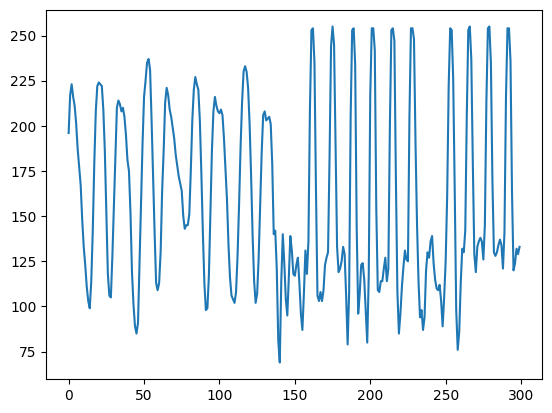

In [444]:
image = cv2.imread('ModulePictures/20UPGM23211355_PPPV2_46_AfterBonding.jpg')
left = 740
right = 6130
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
n = grey.shape[0]
plt.plot(np.arange(grey.shape[0])[:300], grey[:,left][:300])

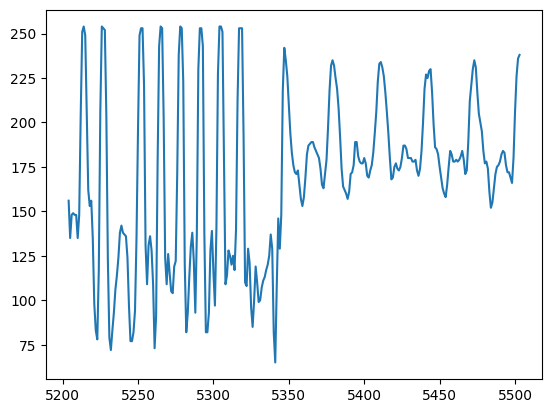

In [440]:
plt.plot(np.arange(grey.shape[0])[n-300:], grey[:,right][n-300:])

In [441]:
high, low = crop_lignes(image)

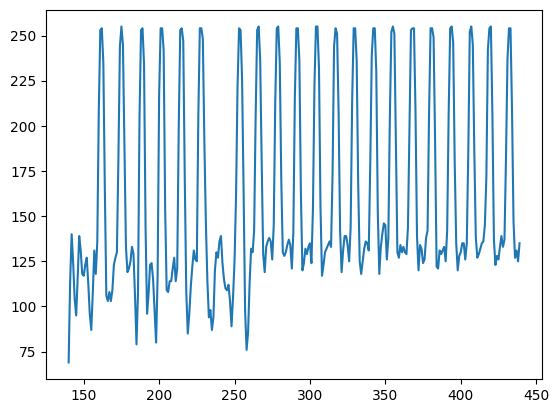

In [442]:
plt.plot(np.arange(low-high)[:300]+high, grey[high:low,left][:300])

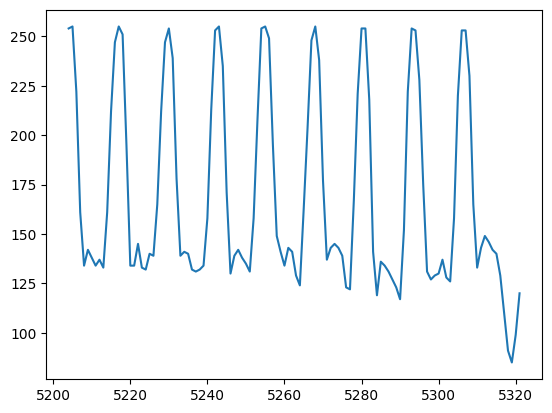

In [21]:
plt.plot(np.arange(low-high)[n-high-300:]+high, grey[high:low,left][n-high-300:])